<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Relationism_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages if needed
!pip install networkx scikit-learn pandas numpy matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# === 1. Load Your CSV ===
# Adjust the file path to your Drive
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# === 2. Filter Passes ===
passes = df[df['typeId'] == 1].copy()
passes = passes[['contestantId', 'playerId', 'x', 'y', 'timeMin', 'timeSec']]
passes = passes.dropna(subset=['x', 'y'])
passes = passes[(passes['x'] > 0) & (passes['y'] > 0)]
passes['timestamp'] = passes['timeMin'] * 60 + passes['timeSec']
passes = passes.sort_values(by='timestamp')

# === 3. Compute Support Proximity ===
support_data = []
for team in passes['contestantId'].unique():
    team_passes = passes[passes['contestantId'] == team]
    for idx, row in team_passes.iterrows():
        x, y = row['x'], row['y']
        timestamp = row['timestamp']
        others = team_passes[
            (team_passes['timestamp'] == timestamp) &
            (team_passes['playerId'] != row['playerId'])
        ]
        distances = np.sqrt((others['x'] - x)**2 + (others['y'] - y)**2)
        count_nearby = (distances <= 15).sum()
        support_data.append({
            'team': team,
            'timestamp': timestamp,
            'support_proximity': count_nearby
        })
support_df = pd.DataFrame(support_data)

# === 4. Compute Metrics in 5-Minute Windows ===
window_metrics = []
for team in passes['contestantId'].unique():
    team_passes = passes[passes['contestantId'] == team]
    team_support = support_df[support_df['team'] == team]
    max_time = team_passes['timestamp'].max()

    for start in range(0, int(max_time), 300):  # 5 min = 300 sec
        end = start + 300
        segment = team_passes[(team_passes['timestamp'] >= start) & (team_passes['timestamp'] < end)]
        if segment.empty: continue

        # Pass network
        segment = segment.copy()
        segment['next_player'] = segment['playerId'].shift(-1)
        segment['next_team'] = segment['contestantId'].shift(-1)
        segment = segment[segment['contestantId'] == segment['next_team']]
        G = nx.DiGraph()
        for _, row in segment.iterrows():
            src, tgt = row['playerId'], row['next_player']
            if G.has_edge(src, tgt):
                G[src][tgt]['weight'] += 1
            else:
                G.add_edge(src, tgt, weight=1)

        if G.number_of_edges() == 0:
            continue

        weights = np.array([d['weight'] for _, _, d in G.edges(data=True)])
        prob_dist = weights / weights.sum()
        entropy = -np.sum(prob_dist * np.log2(prob_dist)) if weights.sum() > 0 else 0
        clustering = nx.average_clustering(G.to_undirected(), weight='weight')
        proximity = team_support[
            (team_support['timestamp'] >= start) & (team_support['timestamp'] < end)
        ]['support_proximity'].mean()

        window_metrics.append({
            'team': team,
            'start_time': start,
            'clustering': clustering,
            'entropy': entropy,
            'proximity': proximity
        })

window_df = pd.DataFrame(window_metrics)

# === 5. Normalize and Calculate Relational Index ===
scaler = MinMaxScaler()
normalized = scaler.fit_transform(window_df[['clustering', 'entropy', 'proximity']])
window_df['relational_index'] = (
    0.4 * normalized[:, 0] +
    0.3 * normalized[:, 2] +
    0.3 * normalized[:, 1]
)

# === 6. Classify Segments as Relational (Threshold > 0.6) ===
window_df['relational'] = window_df['relational_index'] > 0.6

# === 7. Compute Percentage of Relational Time ===
results = window_df.groupby('team')['relational'].mean().reset_index()
results.columns = ['team', 'relational_time_pct']
results['relational_time_pct'] = results['relational_time_pct'] * 100  # in %

# === 8. Save to Drive ===
window_df.to_csv('/content/drive/MyDrive/Outswinger FC/relational_windows.csv', index=False)
results.to_csv('/content/drive/MyDrive/Outswinger FC/relational_summary.csv', index=False)

# === 9. Show Summary ===
print("=== % of Game That Was Relational ===")
print(results)


Mounted at /content/drive
=== % of Game That Was Relational ===
                        team  relational_time_pct
0  9xx15yz7sl5dore0z8d8556ok            15.789474
1  aoaced38v02b2trzucbou0ulz             5.263158


In [ ]:
# Install required packages if needed
!pip install networkx scikit-learn pandas numpy matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import matplotlib.pyplot as plt

# === 1. Set Folder Path ===
folder_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025'
output_summary = []
all_window_data = []

# === 2. Loop Over All CSVs in Folder ===
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

for file_path in csv_files:
    try:
        df = pd.read_csv(file_path)
        passes = df[df['typeId'] == 1].copy()
        passes = passes[['contestantId', 'playerId', 'x', 'y', 'timeMin', 'timeSec']]
        passes = passes.dropna(subset=['x', 'y'])
        passes = passes[(passes['x'] > 0) & (passes['y'] > 0)]
        passes['timestamp'] = passes['timeMin'] * 60 + passes['timeSec']
        passes = passes.sort_values(by='timestamp')

        # === 3. Support Proximity ===
        support_data = []
        for team in passes['contestantId'].unique():
            team_passes = passes[passes['contestantId'] == team]
            for _, row in team_passes.iterrows():
                x, y = row['x'], row['y']
                timestamp = row['timestamp']
                others = team_passes[
                    (team_passes['timestamp'] == timestamp) &
                    (team_passes['playerId'] != row['playerId'])
                ]
                distances = np.sqrt((others['x'] - x)**2 + (others['y'] - y)**2)
                count_nearby = (distances <= 15).sum()
                support_data.append({
                    'team': team,
                    'timestamp': timestamp,
                    'support_proximity': count_nearby
                })
        support_df = pd.DataFrame(support_data)

        # === 4. Metrics in 2-Minute Windows ===
        window_metrics = []
        for team in passes['contestantId'].unique():
            team_passes = passes[passes['contestantId'] == team]
            team_support = support_df[support_df['team'] == team]
            max_time = team_passes['timestamp'].max()

            for start in range(0, int(max_time), 1800):  # 2 min = 120 sec
                end = start + 1800
                segment = team_passes[
                    (team_passes['timestamp'] >= start) &
                    (team_passes['timestamp'] < end)
                ]
                if segment.empty:
                    continue
                segment = segment.copy()
                segment['next_player'] = segment['playerId'].shift(-1)
                segment['next_team'] = segment['contestantId'].shift(-1)
                segment = segment[segment['contestantId'] == segment['next_team']]
                G = nx.DiGraph()
                for _, row in segment.iterrows():
                    src, tgt = row['playerId'], row['next_player']
                    if G.has_edge(src, tgt):
                        G[src][tgt]['weight'] += 1
                    else:
                        G.add_edge(src, tgt, weight=1)
                if G.number_of_edges() == 0:
                    continue
                weights = np.array([d['weight'] for _, _, d in G.edges(data=True)])
                prob_dist = weights / weights.sum()
                entropy = -np.sum(prob_dist * np.log2(prob_dist)) if weights.sum() > 0 else 0
                clustering = nx.average_clustering(G.to_undirected(), weight='weight')
                proximity = team_support[
                    (team_support['timestamp'] >= start) &
                    (team_support['timestamp'] < end)
                ]['support_proximity'].mean()

                window_metrics.append({
                    'file': os.path.basename(file_path),
                    'team': team,
                    'start_time': start,
                    'clustering': clustering,
                    'entropy': entropy,
                    'proximity': proximity
                })

        window_df = pd.DataFrame(window_metrics)

        # === 5. Relational Index Calculation ===
        if not window_df.empty:
            scaler = MinMaxScaler()
            normalized = scaler.fit_transform(window_df[['clustering', 'entropy', 'proximity']])
            window_df['relational_index'] = (
                0.4 * normalized[:, 0] +
                0.3 * normalized[:, 2] +
                0.3 * normalized[:, 1]
            )
            # Threshold = 0.5
            window_df['relational'] = window_df['relational_index'] > 0.5

            summary = window_df.groupby('team')['relational'].mean().reset_index()
            summary.columns = ['team', 'relational_time_pct']
            summary['relational_time_pct'] *= 100
            summary['file'] = os.path.basename(file_path)

            output_summary.append(summary)
            all_window_data.append(window_df)

    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")

# === 6. Combine and Save Outputs ===
summary_df = pd.concat(output_summary, ignore_index=True)
summary_df.to_csv('/content/drive/MyDrive/Outswinger FC/relational_summary_refined.csv', index=False)

window_df_all = pd.concat(all_window_data, ignore_index=True)
window_df_all.to_csv('/content/drive/MyDrive/Outswinger FC/relational_windows_refined.csv', index=False)

# === 7. Team Averages and Ranking ===
avg_df = summary_df.groupby('team')['relational_time_pct'].mean().reset_index()
avg_df = avg_df.sort_values(by='relational_time_pct', ascending=False)
avg_df.to_csv('/content/drive/MyDrive/Outswinger FC/relational_team_ranking.csv', index=False)

# === 8. Plot Time-Series for Each Team ===
import matplotlib.pyplot as plt
teams_to_plot = window_df_all['team'].unique()

for team in teams_to_plot:
    team_df = window_df_all[window_df_all['team'] == team]
    plt.figure(figsize=(12, 4))
    for file in team_df['file'].unique():
        sub = team_df[team_df['file'] == file]
        plt.plot(sub['start_time'], sub['relational_index'], label=f'{file}')
    plt.axhline(0.5, color='gray', linestyle='--', label='Threshold (0.5)')
    plt.title(f'Relational Index Over Time: Team {team}')
    plt.xlabel('Seconds')
    plt.ylabel('Relational Index')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/Outswinger FC/team_{team}_relational_index.png')
    plt.close()

print("✅ All processing complete. CSVs and plots saved to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


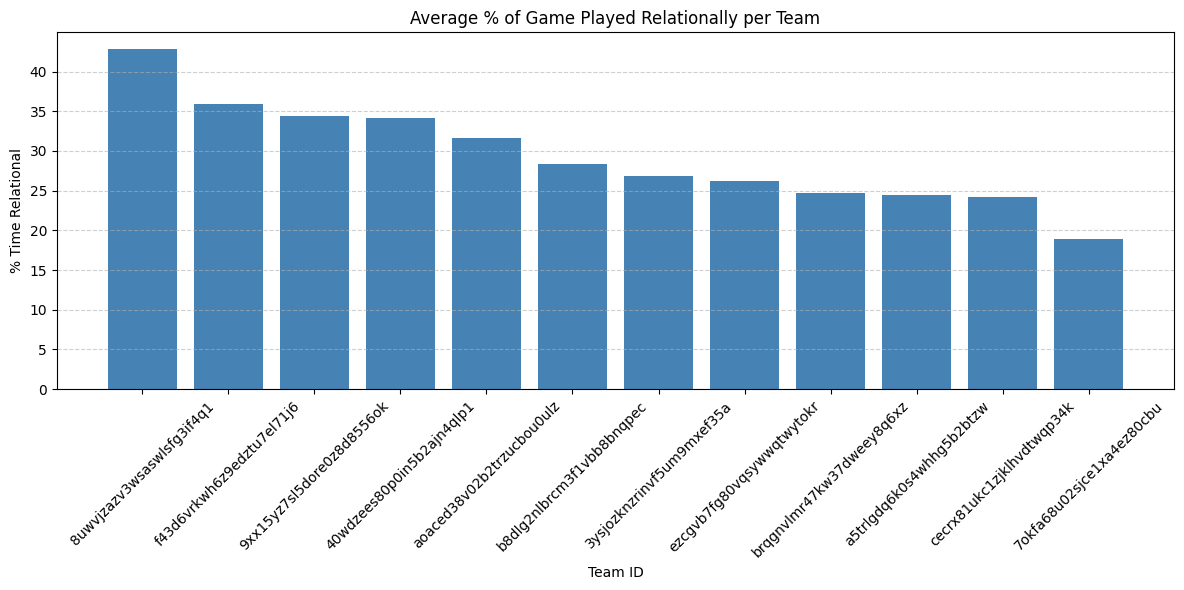

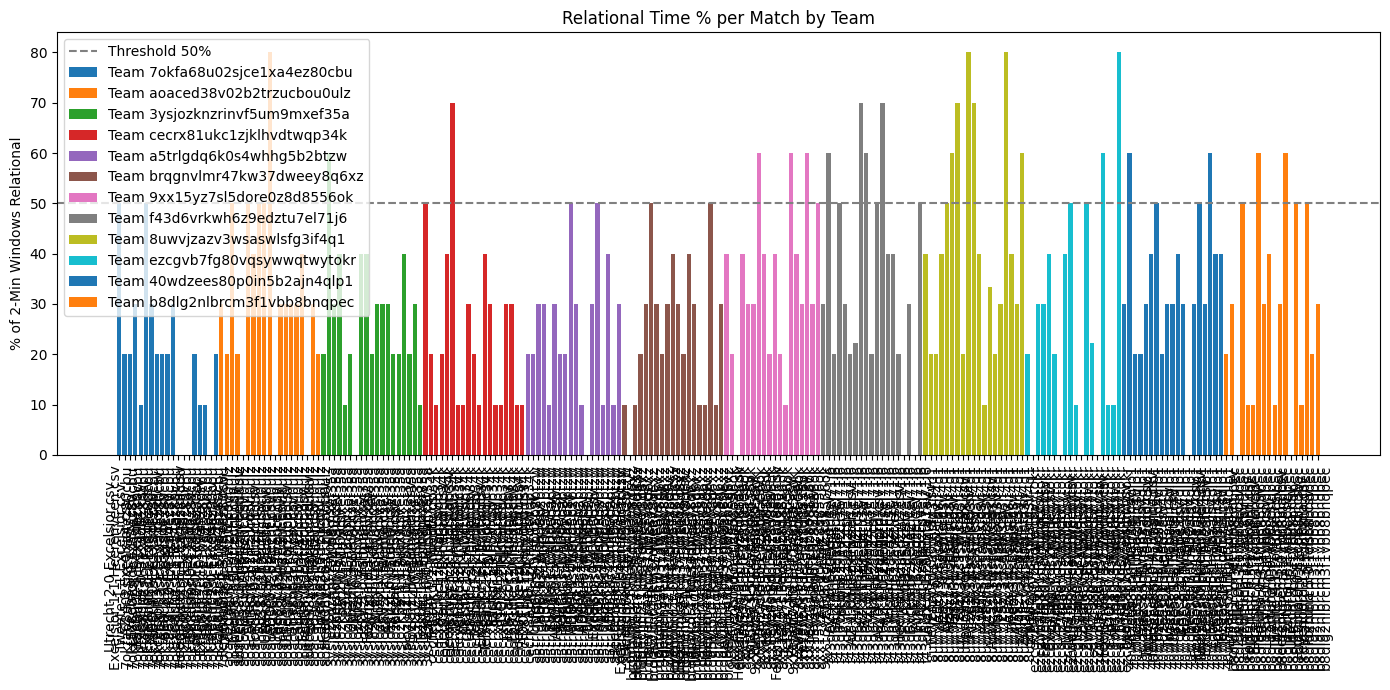

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSVs from Google Drive ===
summary_path = '/content/drive/MyDrive/Outswinger FC/relational_summary_refined.csv'
ranking_path = '/content/drive/MyDrive/Outswinger FC/relational_team_ranking.csv'

summary_df = pd.read_csv(summary_path)
ranking_df = pd.read_csv(ranking_path)

# === 1. Bar Chart: Avg Relational % per Team (Sorted) ===
plt.figure(figsize=(12, 6))
plt.bar(ranking_df['team'], ranking_df['relational_time_pct'], color='steelblue')
plt.title('Average % of Game Played Relationally per Team')
plt.ylabel('% Time Relational')
plt.xlabel('Team ID')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Outswinger FC/avg_relational_by_team.png')
plt.show()

# === 2. Bar Chart: Match-by-Match Relational % ===
plt.figure(figsize=(14, 7))
for team in summary_df['team'].unique():
    team_data = summary_df[summary_df['team'] == team]
    plt.bar(team_data['file'] + '\n' + team, team_data['relational_time_pct'], label=f'Team {team}')

plt.axhline(50, color='gray', linestyle='--', label='Threshold 50%')
plt.title('Relational Time % per Match by Team')
plt.ylabel('% of 2-Min Windows Relational')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Outswinger FC/match_relational_bars.png')
plt.show()
